In [13]:
%matplotlib inline
import copy
import re

import numpy as np
import pandas as pd
import num2words as n2w
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# %% Load corpus data
df = pd.read_csv('../data/interim/Classes_Changed.csv')
corpus = df.loc[:, 'Top1':'Top25']
    
    
def show_wordcloud(text):
    wordcloud = WordCloud(background_color="white").generate(' '.join(text))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
def stats(corpus):
    document_lengths = [len(document) for document in corpus]
    tokens = [token for document in corpus for token in document]
    unique_tokens = set(tokens)
    print("Number of documents: {}".format(len(corpus)))
    print("Document length mean: {:.2f}".format(np.mean(document_lengths)))
    print("Document length variance: {:.2f}".format(np.var(document_lengths)))
    print("Number of tokens: {}".format(len(tokens)))
    print("Number of token types: {}".format(len(unique_tokens)))
    print("Type-Token Ratio: {:.2%}".format(len(unique_tokens) / len(tokens)))
    print()
    show_wordcloud(tokens)
    

Number of documents: 49725
Document length mean: 19.53
Document length variance: 165.99
Number of tokens: 971324
Number of token types: 54459
Type-Token Ratio: 5.61%



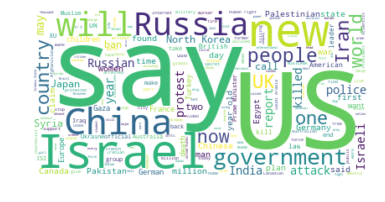

In [14]:
# %% Remove newlines, bounding apostrophes/quotation marks and ensure that there are only single non-trailing spaces
def extract(document):
    if not isinstance(document, str):
        return ''

    document = document.replace('\n', ' ')
    document = re.sub(r" +", " ", document)
    document = re.sub(r"&amp;","&", document)
    match = re.match(r'^b\'(.+?)\'$|^b\"(.+?)\"$|(.+)', document)
    return next(g for g in match.groups() if g is not None) if match else ''


corpus = corpus.applymap(extract)
show_wordcloud(corpus.values.flatten())
ignored_corpus = corpus.applymap(lambda document: word_tokenize(document))
stats(ignored_corpus.values.flatten())

In [3]:
# %% Replace currency symbols with words
currency_dict = {}
currency_regex = ''

SPACE_JOIN_PATTERN = ' '

with open('../data/external/currencies.csv', encoding="utf8") as f_in:
    lines = (line.rstrip('\n') for line in f_in if line.rstrip('\n'))
    symbols = []

    for line in lines:
        symbol, currency = line.split(',')
        currency_dict[symbol] = currency
        symbols.append(symbol)

    currency_regex = "([" + '|'.join(symbols) + "])"

def currenciate(text):
    extracted_currencies = re.split(currency_regex, text)
    translated = [currency_dict[word] if word in currency_dict else word for word in extracted_currencies]
    joined = SPACE_JOIN_PATTERN.join(translated)

    return re.sub(r" +", " ", joined)


corpus = corpus.applymap(currenciate)

Number of documents: 49725
Document length mean: 20.63
Document length variance: 187.45
Number of tokens: 1025605
Number of token types: 51661
Type-Token Ratio: 5.04%



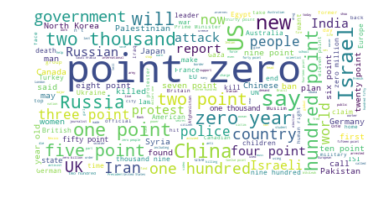

In [4]:
# %% Change existing numbers to words
def numbers_to_words(text):
    numbers = re.findall('[-+]?\d*\.\d+|\d*,\d+|\d+', text)
    for n in numbers:
        convertible = n.replace(",", ".")
        text = text.replace(n, " " + n2w.num2words(convertible) + " ", 1)

    return re.sub(r" +", " ", text)


ignored_corpus = corpus.applymap(numbers_to_words)
ignored_corpus = ignored_corpus.applymap(lambda document: word_tokenize(document))
stats(ignored_corpus.values.flatten())

Number of documents: 49725
Document length mean: 20.40
Document length variance: 179.08
Number of tokens: 1014404
Number of token types: 54742
Type-Token Ratio: 5.40%



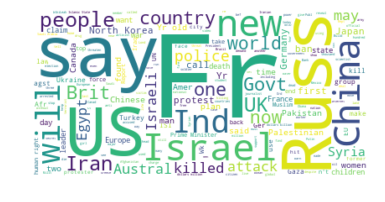

In [5]:
# %% Process all documents and abbreviate adequate words
class Trie():
    class Node():
        def __init__(self, value=None):
            self._children = dict()
            self._value = value

        @property
        def value(self):
            return self._value

        def insert(self, key, value, default=None):
            if len(key) > 0:
                if key[0] not in self._children:
                    self._children[key[0]] = Trie.Node(value=copy.deepcopy(default))
                self._children[key[0]].insert(key[1:], value, default)
            else:
                self._value = value

        def get(self, key, longest_match=False):
            if len(key) > 0:
                if key[0] not in self._children:
                    if longest_match:
                        return self._value
                    else:
                        raise KeyError()

                value = self._children[key[0]].get(key[1:], longest_match)
                return value if value else self._value
            else:
                return self._value

        def __contains__(self, key):
            if len(key) > 0:
                if key[0] not in self._children:
                    return False
                return self._children[key[0]].__contains__(key[1:])
            else:
                return True

        def is_leaf(self, key):
            if len(key) > 0:
                if key[0] not in self._children:
                    raise KeyError()
                return self._children[key[0]].is_leaf(key[1:])
            else:
                return not self._children

    def __init__(self, default=None, longest_match=False):
        self._default = default
        self._longest_match = longest_match
        self._root = Trie.Node(default)

    def __setitem__(self, key, value):
        self._root.insert(key, value, self._default)

    def __getitem__(self, key):
        return self._root.get(key, self._longest_match)

    def __contains__(self, key):
        return self._root.__contains__(key)

    def is_leaf(self, key):
        return self._root.is_leaf(key)


SPLIT_PATTERN = re.compile(r'(\W+)')
JOIN_PATTERN = ''
TRIE = Trie(longest_match=True)

with open('../data/external/abbreviations.csv', encoding="utf8") as f_in:
    for line in f_in:
        line = line.rstrip('\n')
        phrase, abbreviation = list(map(SPLIT_PATTERN.split, line.split(',')))
        TRIE[phrase] = (phrase, abbreviation)


def abbreviate(text):
    wrong_words = SPLIT_PATTERN.split(text)
    correct_words = []

    i = 0
    while i < len(wrong_words):
        result = TRIE[wrong_words[i:]]
        if result:
            current_wrong_words, current_correct_words = result
            i += len(current_wrong_words)
        else:
            current_correct_words = wrong_words[i]
            i += 1
        correct_words += current_correct_words

    return JOIN_PATTERN.join(correct_words)


ignored_corpus = corpus.applymap(abbreviate)
ignored_corpus = ignored_corpus.applymap(lambda document: word_tokenize(document))
stats(ignored_corpus.values.flatten())

Number of documents: 49725
Document length mean: 19.53
Document length variance: 165.99
Number of tokens: 971346
Number of token types: 54449
Type-Token Ratio: 5.61%



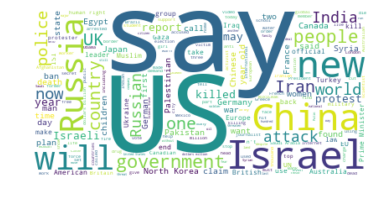

In [6]:
# %% Tokenize documents using NLTK
corpus = corpus.applymap(lambda document: word_tokenize(document))
stats(corpus.values.flatten())

Number of documents: 49725
Document length mean: 19.53
Document length variance: 165.99
Number of tokens: 971346
Number of token types: 43198
Type-Token Ratio: 4.45%



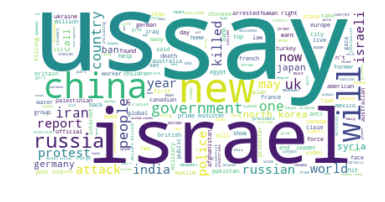

In [7]:
# %% Lowercase documents
corpus = corpus.applymap(lambda document: [word.lower() for word in document])
stats(corpus.values.flatten())

Number of documents: 49725
Document length mean: 13.86
Document length variance: 68.60
Number of tokens: 689211
Number of token types: 43061
Type-Token Ratio: 6.25%



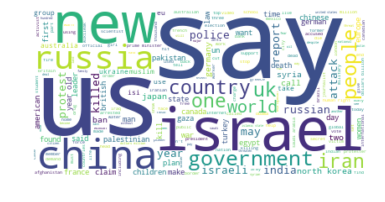

In [8]:
# %% Remove stopwords
stoplist = stopwords.words('english')
corpus = corpus.applymap(lambda document: [word for word in document if word not in stoplist])
stats(corpus.values.flatten())

Number of documents: 49725
Document length mean: 13.86
Document length variance: 68.60
Number of tokens: 689211
Number of token types: 38736
Type-Token Ratio: 5.62%



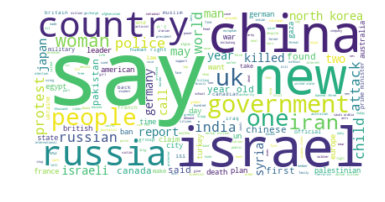

In [9]:
# %% Use lemmatizer to reduce dimensionality
lemmatizer = WordNetLemmatizer()
corpus = corpus.applymap(lambda document: [lemmatizer.lemmatize(word) for word in document])
stats(corpus.values.flatten())

Number of documents: 49725
Document length mean: 13.86
Document length variance: 68.60
Number of tokens: 689211
Number of token types: 36042
Type-Token Ratio: 5.23%



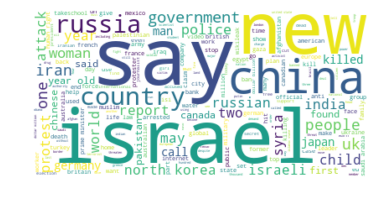

In [10]:
# %% Remove non alphanumeric characters
sanitize = lambda word: re.sub(r'[^0-9A-Za-z ]+', ' ', word).strip()
corpus = corpus.applymap(lambda document: [sanitize(word) for word in document])
stats(corpus.values.flatten())

In [11]:
# # %% Remove tokens shorter than 3
# corpus = corpus.applymap(lambda document: [word for word in document if len(word) > 3])
# stats(corpus.values.flatten())
print('Skipped')

Skipped
